# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [110]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


model: ring in front of diffuse oscillating component and noise

In [111]:
DEVICE = 'cuda:0'
NDIM = 1 # number of parameters
SIGMA = 0.3

In [112]:
SIGMA = 0.1
w=0.05
def model(z,dat=None):
    grid = np.linspace(0, 1, 50, 50)
    X, Y = np.meshgrid(grid, grid)
    
    if dat is None:
        dat=np.random.uniform(0,1,(6))
    
    #x01, y01, r1, w1,fx,fy,Amp = z[0], z[1], z[2]*0.4+0.2, z[3]*0.1+0.05,\
    #    z[4]*6*np.pi,z[5]*6*np.pi,z[6]
    #x01, y01, r1, w1,x02, y02, r2, w2 = z[0], z[1], z[2]*0.4+0.2, z[3]*0.1+0.05,\
    #    z[4], z[5], z[6]*0.4+0.2, z[7]*0.1+0.05
    #x01, y01, r1,x02, y02, r2 = z[0], z[1], z[2]*0.4+0.2, z[3], z[4], z[5]*0.4+0.2
    x1,y1,x2,y2,x3,y3,r=dat[0],dat[1],dat[2],dat[3],dat[4],dat[5],z[0]*0.4#,z[7],z[8],z[9],z[10]*0.4
    
    #R1 = ((X-x01)**2 + (Y-y01)**2)**0.5+0.3*Amp*np.cos(fx*X)*np.sin(fy*Y)
    R1 = ((X-x1)**2 + (Y-y1)**2)**0.5
    R2 = ((X-x2)**2 + (Y-y2)**2)**0.5
    R3 = ((X-x3)**2 + (Y-y3)**2)**0.5
    #R4 = ((X-x4)**2 + (Y-y4)**2)**0.5
    #R5 = ((X-x5)**2 + (Y-y5)**2)**0.5
    
    #mu = np.exp(-(R1-r1)**2/w1**2/2)+np.exp(-(R2-r2)**2/w2**2/2)#0.3*Amp*np.cos(fx*X)*np.sin(fy*Y)
    #mu = np.exp(-(R1-r1)**2/0.1**2/2)+np.exp(-(R2-r2)**2/0.1**2/2)#0.3*Amp*np.cos(fx*X)*np.sin(fy*Y)
    mu = np.exp(-(R1-r)**2/w**2/2)+np.exp(-(R2-r)**2/w**2/2)+np.exp(-(R3-r)**2/w**2/2)#+np.exp(-(R4-r)**2/w**2/2)+np.exp(-(R5-r)**2/w**2/2)
    x = mu
    return x
def noisemodel(x, z = None, noiselevel = 1.):
    n = np.random.randn(*x.shape)*SIGMA  #*noiselevel
    return x + n

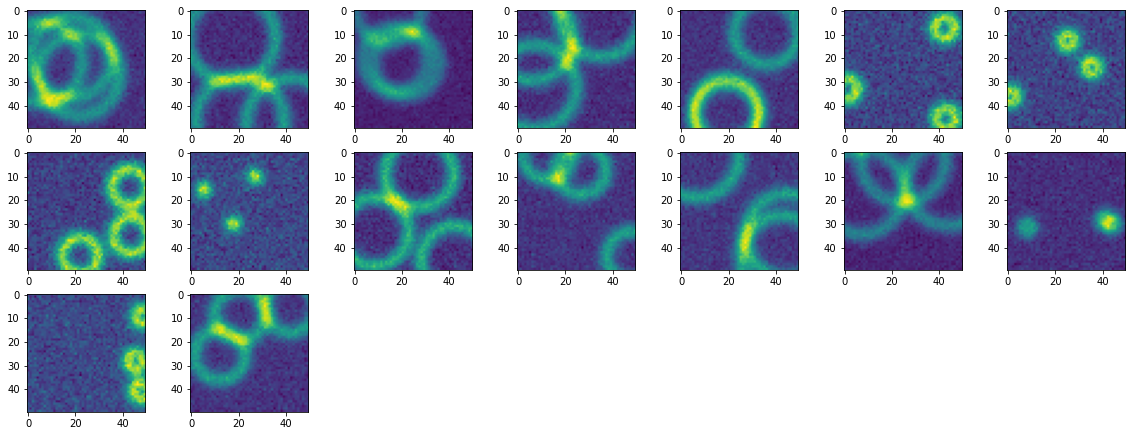

In [113]:
# Random image realizations

plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 7, i+1)
    z = np.random.rand(7)
    x = model(z)
    x = noisemodel(x)
    plt.imshow(x)

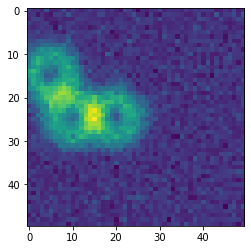

In [114]:
dd=np.array([0.1,0.3,0.4,0.5,0.2,0.5])
z0 = np.array([0.2])
x0 = noisemodel(model(z0,dat=dd))
plt.imshow(x0)

In [6]:
# Fisher analysis
grad = []

for i in range(0, NDIM):
    dz = np.zeros(NDIM)
    d = 0.001
    dz[i] += d
    g = (model(z0+dz) - model(z0))/d
    grad.append(g)

I = np.zeros((NDIM, NDIM))

for i in range(NDIM):
    for j in range(NDIM):
        I[i, j] = (grad[i]*grad[j]).sum()/SIGMA**2
        
        
Cov = np.linalg.inv(I)
err = np.diag(Cov)**0.5
print(err)

[5.13867283e-06]


In [115]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv0a = torch.nn.Conv2d(1, 100, 1)
        #self.conv0b = torch.nn.Conv2d(100, 1, 1)
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        #x = self.conv0a(x)
        #x = torch.relu(x)
        #x = self.conv0b(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [9]:
import time

In [116]:
# Instantiate network
sw = swyft.SWYFT(x0, model, zdim = NDIM, device = DEVICE, head = Head, noisemodel = noisemodel)
ch1=time.time()
sw.run(nworkers=0, nrounds = 4, max_epochs = 1000, early_stopping_patience = 3, nsamples = 20000, nbatch = 32, recycle_net = False, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Adding samples.: 100%|██████████| 19831/19831 [00:00<00:00, 64588.28it/s]


Adding 19831 new samples.


Extracting samples.: 100%|██████████| 19831/19831 [00:00<00:00, 53063.63it/s]


Extracted 19831 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 14
Validation losses: [1.7566773444414139, 1.648838497698307, 1.6312186270952225, 1.4874890446662903, 1.401056069880724, 1.3855000138282776, 1.4401057623326778, 1.3608624450862408, 1.400863591581583, 1.481035701930523, 1.2837489284574986, 1.346851173788309, 1.5184880457818508, 1.308554407209158]
LR iteration 1
Total epochs: 4
Validation losses: [1.205187525600195, 1.2607967853546143, 1.226971447467804, 1.2437784671783447]
LR iteration 2
Total epochs: 6
Validation losses: [1.2087741009891033, 1.2081201896071434, 1.1853065267205238, 1.1877805963158607, 1.2500706389546394, 1.228447686880827]


Adding samples.: 100%|██████████| 20138/20138 [00:00<00:00, 40474.79it/s]


Adding 14891 new samples.


Extracting samples.: 100%|██████████| 34722/34722 [00:00<00:00, 42291.67it/s]


Extracted 20243 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 14
Validation losses: [1.7457860559225082, 1.4594961516559124, 1.5563212931156158, 1.32574313133955, 1.3066742941737175, 1.1754404157400131, 1.1339800171554089, 1.1431779637932777, 1.1374203115701675, 1.128669522702694, 1.0887708775699139, 1.4183080680668354, 1.1201119534671307, 1.1359915547072887]
LR iteration 1
Total epochs: 5
Validation losses: [1.0800211131572723, 1.006556373089552, 1.0300083570182323, 1.048295110464096, 1.0368537828326225]
LR iteration 2
Total epochs: 12
Validation losses: [1.0193557627499104, 1.0139141120016575, 1.0121424086391926, 1.0331208109855652, 1.0012919399887323, 1.0450261570513248, 0.9819783456623554, 0.9758430793881416, 0.9590013399720192, 1.044475268572569, 1.0629729814827442, 1.020130731165409]


Adding samples.: 100%|██████████| 20065/20065 [00:00<00:00, 32199.40it/s]


Adding 15034 new samples.


Extracting samples.: 100%|██████████| 49756/49756 [00:01<00:00, 35456.02it/s]


Extracted 20126 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 9
Validation losses: [2.7725874334573746, 2.46701717376709, 2.0845043286681175, 1.972246192395687, 1.950695440173149, 1.8135677948594093, 1.9083840399980545, 1.8444362878799438, 1.8826167806982994]
LR iteration 1
Total epochs: 5
Validation losses: [1.7396075204014778, 1.6656771153211594, 1.7105793803930283, 1.7550029903650284, 1.7501405477523804]
LR iteration 2
Total epochs: 12
Validation losses: [1.7252119854092598, 1.7454384341835976, 1.704670175909996, 1.7461535334587097, 1.7000037282705307, 1.6802497655153275, 1.6858400255441666, 1.716583952307701, 1.6741812452673912, 1.7207888439297676, 1.6901773288846016, 1.6878395974636078]


Adding samples.: 100%|██████████| 19980/19980 [00:00<00:00, 26633.14it/s]


Adding 1745 new samples.


Extracting samples.: 100%|██████████| 51501/51501 [00:01<00:00, 30871.11it/s]


Extracted 20161 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 6
Validation losses: [2.7725889831781387, 2.772591784596443, 2.7725887298583984, 2.7725887298583984, 2.772589221596718, 2.7725889086723328]
LR iteration 1
Total epochs: 24
Validation losses: [2.7689639925956726, 2.720219135284424, 2.457631900906563, 2.3215923085808754, 2.2714235186576843, 2.153777338564396, 2.123019888997078, 2.102817326784134, 2.1069197207689285, 2.0031713992357254, 1.9753323271870613, 2.0112899467349052, 1.9388975352048874, 1.90138840675354, 1.8563092276453972, 1.8418056964874268, 1.832840770483017, 1.8053231090307236, 1.8315353095531464, 1.8000355809926987, 1.751234270632267, 1.7676901519298553, 1.8526052683591843, 1.7976436987519264]
LR iteration 2
Total epochs: 6
Validation losses: [1.724619321525097, 1.6964557841420174, 1.673726573586464, 1.6898818016052246, 1.6877488493919373, 1.6790289655327797]
18.449331637223562


In [117]:
sw.ds.__len__()

51501

In [119]:
#torch.save(sw.net1d_store[-1],'threeRingsNetwork.pt')
torch.save(sw.post1d_store[-1],'threeRingsPost.pt')

2.503059603752077


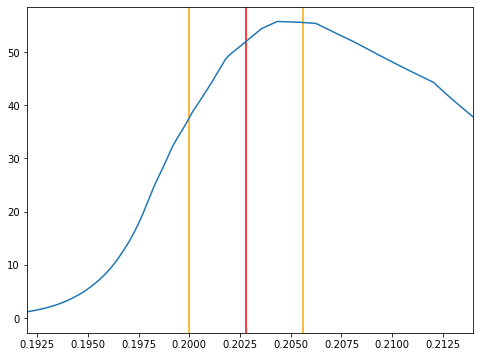

In [118]:
plt.figure(figsize=(8, 6))
for i in [0]:
    z, p = sw.posterior(i, version = -1)
    #plt.axvline(z0[i])
    plt.axvline(.2028,color='red')
    plt.axvline(.2028+.0028,color='orange')
    plt.axvline(.2028-.0028,color='orange')
    #plt.plot(z, stats.norm.pdf(z, z0[i], err[i]), 'k:')
    plt.plot(z, p)
    s = swyft.get_stats(z, p)
    print(s['err68']/.0028)
plt.xlim([0.192, 0.214]);

In [80]:
len(sw.data_store)

80

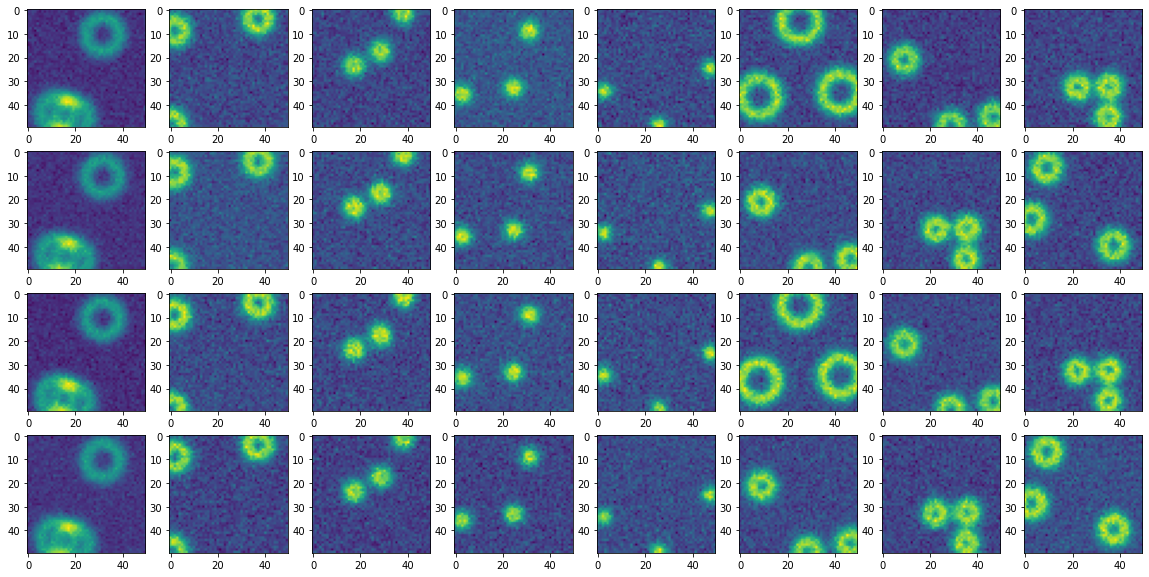

In [18]:
# Training data in different rounds (without noise)

plt.figure(figsize=(20, 10))
counter = 0
for r in range(12,16):
    imgs = swyft.get_x(sw.data_store[r])
    for i in range(8):
        counter += 1
        plt.subplot(4, 8, counter)
        plt.imshow(imgs[i])

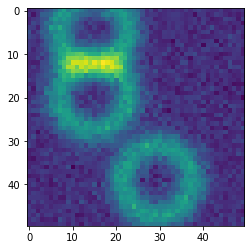

In [88]:
dd=np.array([0.3,0.1,0.3,0.4,0.6,0.8])
z1 = np.array([0.4])
x1 = noisemodel(model(z1,dat=dd))
plt.imshow(x1)

In [120]:
sw2 = swyft.SWYFT(x1, model, datastore=sw.ds, zdim = NDIM, device = DEVICE, head = Head, noisemodel = noisemodel)
ch1=time.time()
sw2.run(nworkers=0, nrounds = 4, max_epochs = 1000, early_stopping_patience = 3, nsamples = 20000, nbatch = 32, recycle_net = False, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Extracting samples.: 100%|██████████| 51501/51501 [00:01<00:00, 26712.59it/s]


Extracted 19696 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 11
Validation losses: [1.7916056960821152, 1.7057383581995964, 1.4399310797452927, 1.4425755552947521, 1.3861301876604557, 1.4164509698748589, 1.2624757960438728, 1.2138512954115868, 1.259860124439001, 1.2955028750002384, 1.303184200078249]
LR iteration 1
Total epochs: 8
Validation losses: [1.1806979067623615, 1.146775359287858, 1.196906939148903, 1.1831841487437487, 1.1328336093574762, 1.2686180993914604, 1.2291260287165642, 1.218082832172513]
LR iteration 2
Total epochs: 9
Validation losses: [1.181526817381382, 1.1654974818229675, 1.1471382416784763, 1.185843514278531, 1.1659358963370323, 1.1127203609794378, 1.1672242693603039, 1.1704939845949411, 1.1787571106106043]


Adding samples.: 100%|██████████| 19984/19984 [00:00<00:00, 24700.43it/s]


Adding 14183 new samples.


Extracting samples.: 100%|██████████| 65684/65684 [00:02<00:00, 24632.25it/s]


Extracted 20047 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 13
Validation losses: [1.9893646538257599, 1.781012624502182, 1.663843147456646, 1.6020599603652954, 1.5422999262809753, 1.5502133518457413, 1.525061957538128, 1.4840236008167267, 1.5078786797821522, 1.4594177529215813, 1.5034913308918476, 1.4799890406429768, 1.4694199860095978]
LR iteration 1
Total epochs: 4
Validation losses: [1.4005045555531979, 1.4271941147744656, 1.4366402886807919, 1.5176046155393124]
LR iteration 2
Total epochs: 5
Validation losses: [1.370977696031332, 1.3613487780094147, 1.4510928764939308, 1.417905531823635, 1.403970129787922]


Adding samples.: 100%|██████████| 20145/20145 [00:00<00:00, 24357.16it/s]


Adding 11257 new samples.


Extracting samples.: 100%|██████████| 76941/76941 [00:02<00:00, 28053.67it/s]


Extracted 20199 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 10
Validation losses: [2.2802278473973274, 2.151600904762745, 2.0272899121046066, 1.837894007563591, 1.8335338681936264, 1.832187332212925, 1.6876649484038353, 1.7863596081733704, 1.7175235599279404, 1.8751222789287567]
LR iteration 1
Total epochs: 5
Validation losses: [1.7714827358722687, 1.6879202648997307, 1.708114817738533, 1.6882544159889221, 1.7327478229999542]
LR iteration 2
Total epochs: 8
Validation losses: [1.7318636700510979, 1.6902468726038933, 1.6832285933196545, 1.714659921824932, 1.6817326620221138, 1.7047961317002773, 1.686904951930046, 1.7257923930883408]


Adding samples.: 100%|██████████| 19965/19965 [00:00<00:00, 20809.62it/s]


Adding 5395 new samples.


Extracting samples.: 100%|██████████| 82336/82336 [00:03<00:00, 26060.71it/s]


Extracted 20065 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 14
Validation losses: [2.771697223186493, 2.2985634729266167, 2.108689308166504, 1.9617543518543243, 1.902593471109867, 1.8398951143026352, 1.8121773526072502, 1.8288030251860619, 1.758563108742237, 1.7686406001448631, 1.7015034705400467, 1.7518668472766876, 1.7915819697082043, 1.8503239080309868]
LR iteration 1
Total epochs: 6
Validation losses: [1.6852878704667091, 1.7384190261363983, 1.6458575502038002, 1.7312154322862625, 1.650702364742756, 1.6745541878044605]
LR iteration 2
Total epochs: 5
Validation losses: [1.636141698807478, 1.622880782932043, 1.6937800645828247, 1.7009532153606415, 1.6413679085671902]
15.881028242905934


1.7466501776645937


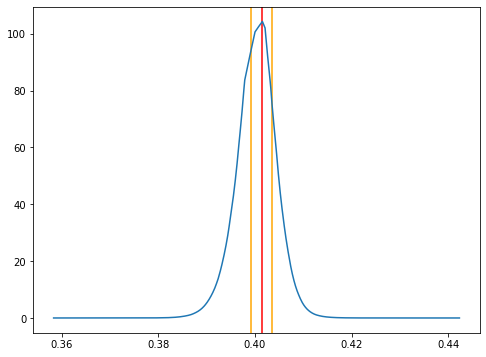

In [121]:
plt.figure(figsize=(8, 6))
for i in [0]:
    z, p = sw2.posterior(i, version = -1)
    #plt.axvline(z0[i])
    plt.axvline(.4014,color='red')
    plt.axvline(.4014+.0022,color='orange')
    plt.axvline(.4014-.0022,color='orange')
    #plt.plot(z, stats.norm.pdf(z, z0[i], err[i]), 'k:')
    plt.plot(z, p)
    s = swyft.get_stats(z, p)
    print(s['err68']/.0022)
#plt.xlim([0.192, 0.214]);

In [122]:
torch.save(sw2.post1d_store[-1],'threeRingsPost2.pt')

# 2-dim plots

In [ ]:
ch1=time.time()
sw.comb([[0, 1]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

In [ ]:
zgrid, lnLgrid = sw.posterior([0, 1])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [ ]:
ch1=time.time()
sw.comb([[0, 2]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

In [ ]:
zgrid, lnLgrid = sw.posterior([0, 2])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [ ]:
ch1=time.time()
sw.comb([[0, 3]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

In [ ]:
zgrid, lnLgrid = sw.posterior([0, 3])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [ ]:
ch1=time.time()
sw.comb([[1,2]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

In [ ]:
zgrid, lnLgrid = sw.posterior([1,2])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [ ]:
ch1=time.time()
sw.comb([[1,3]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

In [ ]:
zgrid, lnLgrid = sw.posterior([1,3])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [ ]:
ch1=time.time()
sw.comb([[2,3]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

In [ ]:
zgrid, lnLgrid = sw.posterior([2,3])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])